# Module 5: Yelp

<img src="images/yelp.png" alt="Yelp Dataset challenge" width="120" style="float:right"/>

Yelp helps people find local businesses based on reviews, preferences, and recommendations. Over 180 million reviews had been written on the platform as of the end of 2018. Since 2013, Yelp has run the [Yelp Dataset challenge](https://www.yelp.com/dataset/challenge), a competition that encourages people to explore and research Yelp’s open dataset.

As of Round 12 (conducted in 2018) of the challenge, the open dataset contained:

* Over 7 million reviews plus tips
* Over 1.5 million users and 280,000 pictures
* Over 188,000 businesses with 1.4 million attributes
* 10 metropolitan areas

## Yelp Social Network

As well as writing and reading reviews about businesses, users of Yelp form a social network. Users can send friend requests to other users they’ve come across while browsing Yelp.com, or they can connect their address books or Facebook graphs.

Before we get started, let's quickly take a look at the [Yelp website](https://www.yelp.co.uk/london).

In this notebook we'll be using Neo4j, pandas, and matplotlib. Let's import those libraries:

In [2]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## The Yelp Graph

This dataset is much bigger than the ones we've worked with so far, so we've created a Neo4j Sandbox with the data from Phoenix in 2018.

We can create a sandbox by navigating to https://neo4j.com/sandbox-v2-dev/, and launching the 'Yelp Sandbox'. Once we've done that we should see the following screen:

![](images/Selection_608.png)

## Connect to Neo4j

Let's create a connection to our sandbox. We'll need to update the following code:

In [3]:
user = "neo4j"
password = "allegation-umbrellas-money"
# driver = GraphDatabase.driver("bolt://<IP Address>:<Bolt Port>", auth=(user, password))
driver = GraphDatabase.driver("bolt://54.163.2.194:32874", auth=(user, password))

## A Quick Overview of the Yelp Data

Let's execute some exploratory queries to see what data we'll be working with. The following code calculates the cardinates of node labels in the database:

In [12]:
result = {"label": [], "count": []}
with driver.session() as session:
    labels = [row["label"] for row in session.run("CALL db.labels()")]
    for label in labels:
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
df = pd.DataFrame(data=result)
df.sort_values("count", ascending=False)

,label,count
3,Review,677379
2,User,330678
5,Photo,30780
0,Business,27455
6,Label,2542
1,Category,1142
4,City,2


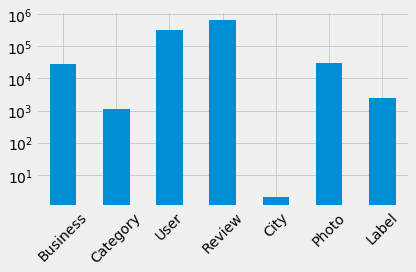

In [13]:
plt.style.use('fivethirtyeight')
ax = df.plot(kind='bar', x='label', y='count', legend=None)
ax.xaxis.set_label_text("")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And now we'll do the same thing for relationship types:

In [14]:
result = {"relType": [], "count": []}
with driver.session() as session:
    rel_types = [row["relationshipType"] for row in session.run
    ("CALL db.relationshipTypes()")]
    for rel_type in rel_types:
        query = f"MATCH ()-[:`{rel_type}`]->() RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["relType"].append(rel_type)
        result["count"].append(count)
df = pd.DataFrame(data=result)
df.sort_values("count", ascending=False)

,relType,count
1,FRIENDS,1208624
2,WROTE,677379
8,HAS_LABEL,250020
3,REVIEWS,115847
0,IN_CATEGORY,111731
6,WROTE_TIP,75949
5,HAS_PHOTO,30780
4,IN_CITY,27455
9,SIMILAR,1936
7,NARROWER_THAN,1499


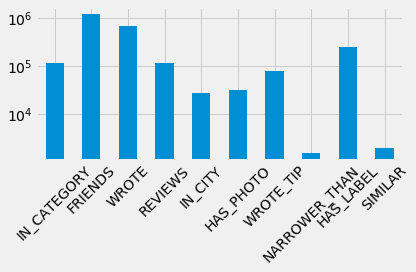

In [16]:
plt.style.use('fivethirtyeight')
ax = df.plot(kind='bar', x='relType', y='count', legend=None)
ax.xaxis.set_label_text("")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Yelp reviews are written for businesses that are tagged with a category. Let's run the following query to discover the most popular categories based on business reviews:

In [75]:
query = """
MATCH (category:Category)
RETURN category.name AS category,
       size((category)<-[:IN_CATEGORY]-()) AS businesses,
       size((:Review)-[:REVIEWS]->(:Business)-[:IN_CATEGORY]->(category)) AS reviews
ORDER BY reviews DESC
LIMIT 10
"""

with driver.session() as session:
    rows = session.run(query)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,businesses,category,reviews
0,5341,Restaurants,62002
1,2793,Food,22005
2,1307,Nightlife,20832
3,1150,Bars,19887
4,620,Breakfast & Brunch,13861
5,673,American (New),13667
6,740,American (Traditional),11706
7,880,Mexican,10262
8,3016,Beauty & Spas,9794
9,4608,Shopping,9734


It looks like the 'Restaurants' category could be a good choice - it has lots of businesses and reviews to work with.

## Restaurant App

In this module we're going to build out the queries for a Yelp restaurant app.

To add well-liked recommendations to our app, we start by finding the most-rated restaurants. We can add how well they’ve been rated to understand the actual experience. To see the 10 most-reviewed restaurants and plot their rating distributions, we use the following code:

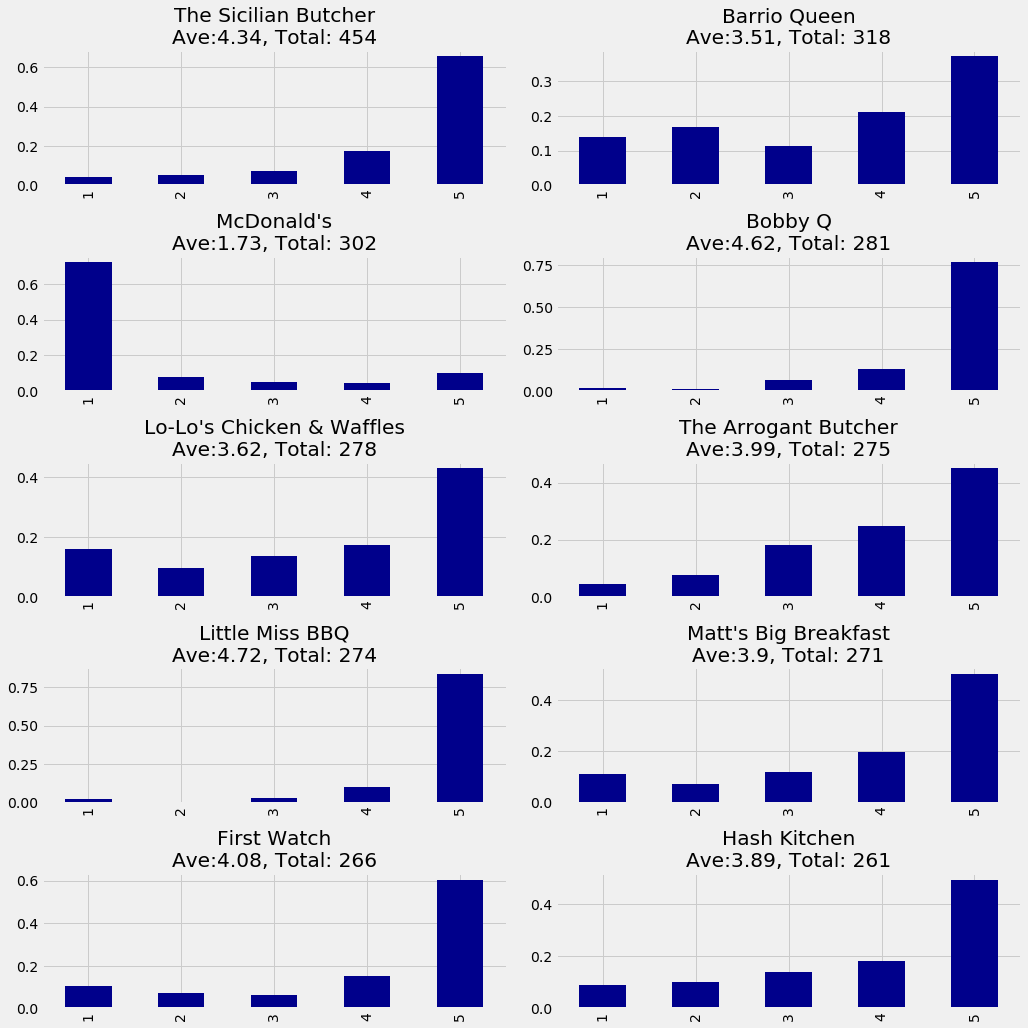

In [35]:
# Find the 10 hotels with the most reviews
query = """
MATCH (review:Review)-[:REVIEWS]->(business:Business),
      (business)-[:IN_CATEGORY]->(category:Category {name: $category})
RETURN business.name AS business, collect(review.stars) AS allReviews
ORDER BY size(allReviews) DESC
LIMIT 10
"""
fig = plt.figure()
fig.set_size_inches(14.5, 14.5)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

params = { "category": "Restaurants"}

with driver.session() as session:    
    result = session.run(query, params)
    for index, row in enumerate(result):
        business = row["business"]
        stars = pd.Series(row["allReviews"])
        total = stars.count()
        average_stars = stars.mean().round(2)
        
        # Calculate the star distribution
        stars_histogram = stars.value_counts().sort_index()
        stars_histogram /= float(stars_histogram.sum())
        
        # Plot a bar chart showing the distribution of star ratings
        ax = fig.add_subplot(5, 2, index+1)
        stars_histogram.plot(kind="bar", legend=None, color="darkblue",
        title=f"{business}\nAve:{average_stars}, Total: {total}")
plt.tight_layout()
plt.show()

These restaurants have lots of reviews, far more than anyone would be likely to read. It would be better to show our users the content from the most relevant reviews and make them more prominent on our app. To do this analysis, we’ll move from basic graph exploration to using graph algorithms

## Finding influential restaurant reviewers

One way we can decide which reviews to feature is by ordering reviews based on the influence of the reviewer on Yelp. We’ll run the PageRank algorithm over the projected graph of all users that have reviewed at least three restaurants.

We'll use the Yelp friend graph as the relationships between users. We need to write a query that projects a subgraph of users with more than three reviews and then executes the PageRank algorithm over that projected subgraph.

Let's understand how that subgraph projection works with a small example. The following graph shows a graph of three mutual freinds - Mark, Arya, and Praveena. Mark and Praveena have both reviewed three hotels and will be part of the projected graph. Arya, on the other hand, has only reviewed one hotel and will therefore be excluded
from the projection.

![](images/friends-of-yelp.svg)

Our projected graph will only include Mark and Praveena, as shown below:

![](images/praveena_mark.svg)

The following query executes the PageRank algorithm over our projected graph and stores the result in the `restaurantPageRank` property on each node:

In [10]:
query = """
CALL algo.pageRank(
  'MATCH (u:User)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->
         (:Category {name: $category})
   WITH u, count(*) AS reviews
   WHERE reviews >= $cutOff
   RETURN id(u) AS id',
  'MATCH (u1:User)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->
         (:Category {name: $category})
   MATCH (u1)-[:FRIENDS]->(u2)
   RETURN id(u1) AS source, id(u2) AS target',{ 
     graph: "cypher", 
     write: true, 
     writeProperty: $writeProperty,
     params: {category: $category, cutOff: $cutOff}
  })
"""

params = {
    "category": "Restaurants",
    "writeProperty": "restaurantPageRank",
    "cutOff": 3
}

with driver.session() as session:    
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,computeMillis,dampingFactor,iterations,loadMillis,nodes,write,writeMillis,writeProperty
0,68,0.85,20,755,4563,True,10,restaurantPageRank


Now let's have a look at the distribution of PageRank values:

In [4]:
query = """
MATCH (u:User)
WHERE not(u[$prop] is null)
RETURN count(u[$prop]) AS count,
       avg(u[$prop]) AS ave,
       percentileDisc(u[$prop], 0.5) AS `50%`,
       percentileDisc(u[$prop], 0.75) AS `75%`,
       percentileDisc(u[$prop], 0.90) AS `90%`,
       percentileDisc(u[$prop], 0.95) AS `95%`,
       percentileDisc(u[$prop], 0.99) AS `99%`,
       percentileDisc(u[$prop], 0.999) AS `99.9%`,
       percentileDisc(u[$prop], 0.9999) AS `99.99%`,
       percentileDisc(u[$prop], 0.99999) AS `99.999%`,
       percentileDisc(u[$prop], 1) AS `100%`
"""

params = {"prop": "restaurantPageRank"}

with driver.session() as session:    
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,100%,50%,75%,90%,95%,99%,99.9%,99.99%,99.999%,ave,count
0,39.103196,0.15,0.323697,0.933487,1.348542,4.542069,11.034871,39.103196,39.103196,0.43476,4563


50% of our users have a score under 0.15, which is the value that they are initialized with by the PageRank algorithm. It seems like this data reflects a power-law distribution with a few very influential reviewers.

Because we only want to find the most influential users, we'll write a query that finds users with a PageRank score in the top 1% of all users. The following query finds users with a PageRank score higher than 4.54

In [8]:
query = """
// Only find users that have a score in the top 1% of users
MATCH (u:User)
WHERE u[$prop] > $score

// Find the top 10 of those users
WITH u ORDER BY u[$prop] DESC
LIMIT 10
RETURN u.name AS name,
       u[$prop] AS pageRank,
       size((u)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->(:Category {name: $category})) AS restReviews,
       size((u)-[:WROTE]->()) AS totalReviews,
       size((u)-[:FRIENDS]-()) AS friends
"""

params = {
    "prop": "restaurantPageRank", 
    "category": "Restaurants",
    "score": 4.54
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,friends,name,pageRank,restReviews,totalReviews
0,2401,Joyce,39.103196,6,72
1,1629,Hailey,23.035766,27,55
2,954,Brittany,12.516548,10,18
3,914,Stephen,11.445319,7,19
4,696,Ria,11.034871,5,19
5,834,Rick,10.114516,6,19
6,956,Jay,9.812927,8,23
7,830,Simon,9.624134,7,30
8,1267,Juan,9.248944,7,62
9,1542,Gabi,9.169528,24,45


## Restaurants Business Consulting


As part of our consulting service, restaurants subscribe to be alerted when an influential visitor writes about their stay so they can take any necessary action. First, we’ll look at ratings of the The Sicilian Butcher, sorted by the most influential reviewers:

In [46]:
query = """
MATCH (b:Business {name: $business})
MATCH (b)<-[:REVIEWS]-(review)<-[:WROTE]-(user)
WHERE not(user[$prop] is null)
RETURN user.name AS name,
       user[$prop] AS pageRank,
       review.stars AS stars
"""

params = {
    "business": "The Sicilian Butcher",
    "prop": "restaurantPageRank"
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])
    df = df.round(2)
    df = df[["name", "pageRank", "stars"]]

top_reviews = df.sort_values(by=["pageRank"], ascending=False).head(10)
top_reviews

,name,pageRank,stars
106,Georgie,7.81,3
120,Jessica,5.74,1
111,Ashley,5.35,5
82,Yuko,4.29,4
7,Cindy,3.88,3
81,Bonnie,3.69,3
2,Dwayne,2.72,4
77,Louis,2.54,5
108,Jennifer,2.49,5
44,Ashley,2.17,5


Jessica has a PageRank score in the top percentile and clearly didn't have a good time at the restaurant! A personal outreach by the restaurant may be warranted.

Georgie, Cindy, and Bonnie all had an average experience (rating of 3), and may also be worth contacting.

### Cross Promotion

After we helped them find influential reviewers, the The Sicilian Butcher has now asked us to help identify other businesses for cross-promotion with help from well-connected customers.

We'll now use the Betweenness Centrality algorithm to work out which reviewers are not only well connected across the whole Yelp network, but might also act as a bridge between different groups.

We're only interested in users who have reviewed lots of restaurants. We'll add a `Reviewer` label to all users that have written more than 5 reviews:

In [50]:
query = """
MATCH (u:User)
WHERE size((u)-[:WROTE]->()) > 5
SET u:Reviewer
"""

with driver.session() as session:
    result = session.run(query, params)
    display(result.summary().counters)

{}

The following query will execute the algorithm and store the result in the `between` property:

In [11]:
query = """
CALL algo.betweenness('Reviewer', 'FRIENDS', {
  write: true, 
  writeProperty: $prop
})
"""

params = {
    "prop": "between"
}

with driver.session() as session:    
    rows = session.run(query, params)
    display(rows.summary().counters)

{}

Before we use these scores in our queries, let’s write a quick exploratory query to see how the scores are distributed:

In [13]:
query = """
MATCH (u:User)
WHERE not(u[$prop] is null)
RETURN count(u[$prop]) AS count,
       avg(u[$prop]) AS ave,
       percentileDisc(u[$prop], 0.5) AS `50%`,
       percentileDisc(u[$prop], 0.75) AS `75%`,
       percentileDisc(u[$prop], 0.90) AS `90%`,
       percentileDisc(u[$prop], 0.95) AS `95%`,
       percentileDisc(u[$prop], 0.99) AS `99%`,
       percentileDisc(u[$prop], 0.999) AS `99.9%`,
       percentileDisc(u[$prop], 0.9999) AS `99.99%`,
       percentileDisc(u[$prop], 0.99999) AS `99.999%`,
       percentileDisc(u[$prop], 1) AS `100%`
"""

params = {"prop": "between2"}

with driver.session() as session:    
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,100%,50%,75%,90%,95%,99%,99.9%,99.99%,99.999%,ave,count
0,9.921710e+06,0.0,159.824481,17320.0,30922.294869,152732.109096,1.300869e+06,7.022190e+06,9.921710e+06,11502.415834,17204


Half of our users have a score of 0, meaning that that are not well connecgted at all. The top 1 percentile (99% column) are on at least 150,000 shortest paths between our set of users.

We can now find out who our superconnectors are by running the following query:

In [14]:
query = """
MATCH(u:User)-[:WROTE]->()-[:REVIEWS]->(:Business {name: $business})
WHERE not(u[$prProp] is null) AND not(u[$bwProp] is null)
RETURN u.name AS user,
       toInteger(u[$bwProp]) AS betweenness,
       u[$prProp] AS pageRank,
       size((u)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->(:Category {name: $category})) AS hotelReviews
ORDER BY u[$bwProp] DESC
LIMIT 10
"""

params = {
    "business": "The Sicilian Butcher",
    "prProp": "restaurantPageRank",
    "bwProp": "between",
    "category": "Restaurants"
}

with driver.session() as session:
    rows = session.run(query, params)

df = pd.DataFrame([dict(record) for record in rows])
df = df.round(2)
df

,betweenness,hotelReviews,pageRank,user
0,477863,21,7.81,Georgie
1,237056,13,4.29,Yuko
2,120057,7,5.74,Jessica
3,107986,23,3.69,Bonnie
4,83116,24,2.72,Dwayne
5,76923,17,3.88,Cindy
6,68347,39,2.49,Jennifer
7,53509,8,5.35,Ashley
8,51953,23,0.87,Rebecca
9,42709,5,1.16,Erika


Some of these users are the same as the ones we saw when analysing the PageRank scores. Rebecca and Erika are interesting, as they have quite low PageRank scores, but seem to be influential across the world of Phoenix Yelp users.

In an effort to reach a wider variety of customers, we’ll look at other preferences these “connectors” display to see what we should promote. Many of these users have also reviewed bars or nightlife, so we can write the following query to find out which ones they like best:

In [16]:
query = """
// Find the top 50 users who have reviewed the Sicilian Butcher
MATCH (u:User)-[:WROTE]->()-[:REVIEWS]->(:Business {name:$business})
WHERE not(u[$prop] is null) AND u[$prop] > 0
WITH u ORDER BY u[$prop] DESC LIMIT 50

// Find the bars and nightlife those users have reviewed in Las Vegas
MATCH (u)-[:WROTE]->(review)-[:REVIEWS]-(business)
WHERE any(cat in $categories WHERE (business)-[:IN_CATEGORY]->(:Category {name: cat})) 

// Only include businesses that have more than 3 reviews by these users
WITH business, avg(review.stars) AS averageReview, count(*) AS numberOfReviews
WHERE numberOfReviews >= 3
RETURN business.name AS business, averageReview, numberOfReviews,
       [(business)-[:IN_CATEGORY]->(cat) | cat.name] AS categories
ORDER BY averageReview DESC, numberOfReviews DESC
LIMIT 10
"""

params = {
    "business": "The Sicilian Butcher",
    "prop": "between",
    "categories": ["Nightlife", "Bars"]
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,averageReview,business,categories,numberOfReviews
0,4.750000,Mowry & Cotton,"[Food, Cocktail Bars, Restaurants, Nightlife, ...",4
1,4.666667,The Covenant,"[Coffee & Tea, Breakfast & Brunch, American (N...",3
2,4.000000,The Porch,"[American (New), Southern, Restaurants, Nightl...",6
3,3.800000,Shake Shack,"[Hot Dogs, Fast Food, Wine & Spirits, Beer, Am...",5
4,3.571429,Barrio Queen,"[Mexican, Restaurants, Food, Nightlife, Bars, ...",7
5,3.250000,Cold Beers & Cheeseburgers - Paradise Valley,"[Restaurants, Bars, Nightlife, Burgers, Americ...",4
6,2.333333,Z'Tejas Southwestern Grill,"[Food, Tex-Mex, Nightlife, Restaurants, Bars, ...",3


We could now recommend that The Sicilian Butcher run a joint promotion with these bars and night clubs to attract new guests from groups that they might not typically reach.

## Finding Similar Categories

While our end users are using the app to find restaurants, we want to showcase other businesses they might be interested in. The Yelp dataset contains more than 1,000 categories, and it seems likely that some of those categories are similar to each other. We’ll use that similarity to make in-app recommendations for new businesses that our users will likely find interesting.

In [94]:
query = """
CALL algo.labelPropagation.stream(
  'MATCH (c:Category) RETURN id(c) AS id',
  'MATCH (c1:Category)<-[:IN_CATEGORY]-()-[:IN_CATEGORY]->(c2:Category)
   WHERE id(c1) < id(c2)
   RETURN id(c1) AS source, id(c2) AS target, count(*) AS weight', 
   {graph: "cypher"})
YIELD nodeId, label
MATCH (c:Category) WHERE id(c) = nodeId
MERGE (sc:SuperCategory {name: "SuperCategory-" + label})
MERGE (c)-[:IN_SUPER_CATEGORY]->(sc)
"""

with driver.session() as session:    
    rows = session.run(query)
    display(rows.summary().counters)

{'labels_added': 222, 'relationships_created': 1142, 'nodes_created': 222, 'properties_set': 222}

In [95]:
query = """
MATCH (sc:SuperCategory)<-[:IN_SUPER_CATEGORY]-(category)
WITH sc, category, size((category)<-[:IN_CATEGORY]-()) as size
ORDER BY size DESC
WITH sc, collect(category.name)[0] as biggestCategory
SET sc.friendlyName = "SuperCat " + biggestCategory
"""

with driver.session() as session:    
    rows = session.run(query)
    display(rows.summary().counters)

{'properties_set': 222}

In [98]:
query = """
MATCH (category:Category {name: $category}),
      (category)-[:IN_SUPER_CATEGORY]->()<-[:IN_SUPER_CATEGORY]-(otherCategory)
RETURN otherCategory.name AS otherCategory,
       size((otherCategory)<-[:IN_CATEGORY]-(:Business)) AS businesses
ORDER BY businesses DESC
LIMIT 10
"""

params = {
    "category": "Restaurants",
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,businesses,otherCategory
0,880,Mexican
1,835,Sandwiches
2,702,Coffee & Tea
3,620,Breakfast & Brunch
4,538,Burgers
5,397,Grocery
6,389,Specialty Food
7,322,Bakeries
8,284,Salad
9,267,Desserts


Now let’s find some businesses with an above-average rating in each of those categories. Before we do that we'll store the average rating for each business in the `averageStars` property:

In [100]:
query = """
MATCH (business:Business)<-[:REVIEWS]-(review)
WITH business, avg(review.stars) AS averageStars
SET business.averageStars = averageStars
"""

with driver.session() as session:    
    rows = session.run(query)
    display(rows.summary().counters)

{'properties_set': 15807}

And now let's find one business in each of the sibling categories of restaurants:

In [108]:
query = """
// Find businesses that have the same SuperCategory as Hotels
MATCH (cat:Category {name: $category}),
      (cat)-[:IN_SUPER_CATEGORY]->()<-[:IN_SUPER_CATEGORY]-(otherCategory),
      (otherCategory)<-[:IN_CATEGORY]-(business)
      
// Select 10 random categories and calculate the 90th percentile star rating
WITH otherCategory, count(*) AS count,
     collect(business) AS businesses,
     percentileDisc(business.averageStars, 0.9) AS p90Stars
ORDER BY rand() DESC
LIMIT 10

// Select businesses from each of those categories that have an average rating
// higher than the 90th percentile using a pattern comprehension
WITH otherCategory, [b in businesses where b.averageStars >= p90Stars] AS businesses
WHERE size(businesses) > 0

// Select one business per category
WITH otherCategory, businesses[toInteger(rand() * size(businesses))] AS business
RETURN otherCategory.name AS otherCategory,
       business.name AS business,
       business.averageStars AS averageStars
"""

params = {
    "category": "Restaurants",
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,averageStars,business,otherCategory
0,4.666667,Playhouse On The Park,Cinema
1,5.000000,Scottsdale Green Belt,Local Flavor
2,5.000000,Angelicious Cakes & Fine Treats,Desserts
3,4.666667,Kim's Chinese Kitchen,Dim Sum
4,5.000000,Filibertos Mexican Food,Mexican
5,5.000000,Water Mart,Ice Delivery
6,5.000000,Best of Europe Meats & Deli,Polish
7,5.000000,The Simple Farm,Farmers Market
8,5.000000,Mercado Y Carniceria El Rancho,Ethnic Grocery
9,5.000000,El Rey De Los Ostiones,Seafood Markets
